In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import log_loss
import lightgbm as lgb
from datetime import datetime

/kaggle/input/15th-data60sec/var_list.csv
/kaggle/input/15th-data60sec/train_label.csv
/kaggle/input/15th-data60sec/test_data.pickle/test_data.pickle
/kaggle/input/15th-data60sec/train_data.pickle/train_data.pickle


In [2]:
train = pd.read_pickle('/kaggle/input/15th-data60sec/train_data.pickle/train_data.pickle')
test = pd.read_pickle('/kaggle/input/15th-data60sec/test_data.pickle/test_data.pickle')
train_label = train['label']

var_list = list(pd.read_csv('/kaggle/input/15th-data60sec/var_list.csv')['var'])

In [3]:
var_list = list(reversed(sorted(list(set(var_list) - set(train.columns[train.isna().any()].tolist() + test.columns[test.isna().any()].tolist())))))

train = train.loc[(train['time'] >= 10),var_list].reset_index(drop=True)
test = test.loc[(test['time'] >= 10),list(set(var_list) - set(['label']))].reset_index(drop=True)

print(train[var_list].shape)
print(test[list(set(var_list) - set(['label']))].shape)

(41400, 2545)
(36000, 2544)


In [4]:
all = pd.concat([train,test],axis=0).reset_index(drop=True)
all_value_cnt = all.nunique()

히스토그램을 보면 알 수 있듯이, numeric과 categorical이 명확하게 나눠진다 

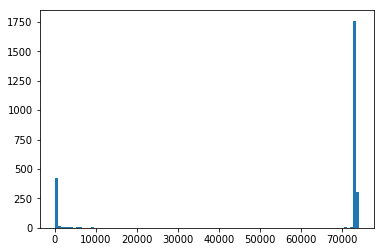

In [5]:
plt.hist(all_value_cnt,bins = 100)
plt.show()

In [6]:
cat_var = list(all_value_cnt[(all_value_cnt < 11) & (all_value_cnt > 2)].index)
bin_var = list(all_value_cnt[all_value_cnt == 2].index)
num_var = list(set(var_list) - set(cat_var) - set(bin_var) - set(['label','id','time']))
etc_var = ['label','id','time']

print('# of binary feature :',len(bin_var))
print('# of categorical feature :',len(cat_var))
print('# of numeric feature :',len(num_var))
print('# of etc feature :',len(etc_var))

# of binary feature : 243
# of categorical feature : 92
# of numeric feature : 2207
# of etc feature : 3


In [7]:
mean_of_num_var = all[num_var].mean().reset_index().rename(columns = {'index' : 'var', 0 : 'mean'})

kmeans = MiniBatchKMeans(n_clusters = 50, batch_size = 10000).fit(mean_of_num_var['mean'].values.reshape(-1,1))
mean_of_num_var['group'] = kmeans.predict(mean_of_num_var['mean'].values.reshape(-1,1))
mean_of_num_var.head()

,var,mean,group
0,V0395,34.743142,40
1,V0162,37.330016,40
2,V1084,0.069716,22
3,V1249,18.713387,0
4,V2994,40.053344,49


### PCA를 통해 numeric 변수들의 차원을 축소한다
- numeric group 별로 차원축소 실시
- group 별로 1/10로 개수를 줄인다
- group 별로 하는 이유는 변수 group 별 분포를 더 잘 살리기 위해서

현재 변수 분류
- binary
- categorical
- num
    - pca
        - group의 value cnt가 50 넘는 그룹만
    - not_pca
- etc
    - id
    - time
    - label

In [8]:
grp_cnt = mean_of_num_var['group'].value_counts()
pca_var = []
pcDF = pd.DataFrame()

for a in tqdm(grp_cnt[grp_cnt > 50].index.tolist()):
    target_var = mean_of_num_var[mean_of_num_var['group'] == a]['var'].tolist()
    pca_var += target_var
    
    data = all[target_var]
    for b in target_var:
        data[b] = StandardScaler().fit_transform(data[b].values.reshape(-1,1))
    
    pca_var_nm = ['group_'+str(a)+'_pc'+str(c+1) for c in range(int(len(target_var)/10))]
    
    pca = PCA(n_components = int(len(target_var)/10))
    principalComponents = pca.fit_transform(data.values)
    pcDF = pd.concat([pcDF,pd.DataFrame(data = principalComponents,
                columns = pca_var_nm)], axis = 1)
    
print('pca result data shape :', pcDF.shape)

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

pca result data shape : (77400, 180)


In [9]:
not_pca_var = list(set(mean_of_num_var['var'].unique()) - set(pca_var))
not_pca_train = all.loc[~all['label'].isnull(), not_pca_var].reset_index(drop = True)
not_pca_test = all.loc[all['label'].isnull(), not_pca_var].reset_index(drop = True)

print(not_pca_train.shape)
print(not_pca_test.shape)



In [34]:
train = pd.concat([train[['label','id']], train[bin_var + cat_var + not_pca_var], pcDF.iloc[:train.shape[0],]],axis=1)
test = pd.concat([test[['id']], test[bin_var + cat_var + not_pca_var], pcDF.iloc[train.shape[0]:,].reset_index(drop=True)],axis=1)

In [37]:
%%time

train = train.groupby('id').rolling(window = 3).mean().drop(columns = ['id']).reset_index().drop(columns = ['level_1']).dropna().reset_index(drop=True)
train_label = train['label']
train_id = train['id']

test = test.groupby('id').rolling(window = 3).mean().drop(columns = ['id']).reset_index().drop(columns = ['level_1']).dropna().reset_index(drop=True)
test_id = test['id']

var_model = list(set(train.columns) & set(test.columns) - set(['id']))

CPU times: user 33.8 s, sys: 959 ms, total: 34.8 s
Wall time: 34.8 s


In [41]:
train

,id,label,V0241,V0242,V0244,V0295,V0301,V0650,V0661,V0965,...,group_29_pc3,group_29_pc4,group_29_pc5,group_29_pc6,group_26_pc1,group_26_pc2,group_26_pc3,group_26_pc4,group_26_pc5,group_26_pc6
0,0,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.026310,-0.046308,0.056537,0.085118,-1.016482,-0.137339,-0.168235,-0.287223,-0.973681,0.319253
1,0,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.033793,0.022892,0.057257,-0.274694,-1.042950,-0.167090,-0.143400,-0.126721,-0.988604,0.274030
2,0,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.045547,-0.053404,0.044242,-0.013962,-1.027246,-0.094688,-0.130670,-0.092504,-0.910300,0.305771
3,0,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.050546,-0.019396,0.053363,-0.143665,-0.992870,0.071168,-0.077338,0.018613,-0.591582,0.145145
4,0,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.061628,-0.037183,0.058138,-0.096996,-1.057164,-0.045856,-0.113084,-0.015578,-0.696855,0.189270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,827,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.560465,-0.072883,0.041725,-0.188920,-1.337490,0.231888,-0.029913,0.226638,0.193479,-0.446107
39740,827,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.568635,-0.022889,0.037029,-0.589832,-1.329558,0.117914,-0.136001,-0.012905,0.273652,-0.664857
39741,827,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.550188,-0.089338,0.122138,-0.246961,-1.268222,0.062836,-0.128262,-0.039988,0.011198,-0.537303
39742,827,110.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.545558,-0.138585,0.155958,-0.075894,-1.288870,0.116845,-0.065398,0.118060,0.022430,-0.489687


In [42]:
def tr_vl_split(train_df, num, seed):    
    '''
    train / validation split 함수
    train 에 모든 label이 최소 한번은 등장 & train과 validation의 id는 겹치지 않도록 split함.
    
    train_df : train 데이터
    num : label 당 몇개의 id를 뽑을 것이냐.
    seed = random seed
    
    '''
    
    np.random.seed(seed)
    
    valid_id = []
    vc = train[['id','label']].drop_duplicates()['label'].value_counts()
    temp = list(vc[vc > num].index)
    for a in temp:
        id_list = list(train_df[train_df['label'] == a]['id'])
        valid_id += random.sample(id_list,num)
    
    train_id = list(set(train_df['id']) - set(valid_id))
    
    x_tr_ = train[train['id'].isin(train_id)]
    y_tr_ = train_label[train['id'].isin(train_id)]

    x_vl_ = train[~train['id'].isin(train_id)]
    y_vl_ = train_label[~train['id'].isin(train_id)]
    
    return x_tr_, y_tr_, x_vl_, y_vl_ 

In [45]:
x_tr, y_tr, x_vl, y_vl = tr_vl_split(train, 3, seed = 1995)

print('train shape :',x_tr.shape)
print('validation shape :',x_vl.shape)
print('test shape :', test.shape)

train shape : (31152, 874)
validation shape : (8592, 874)
test shape : (34560, 873)


In [ ]:
%%time

lgb_tr = lgb.Dataset(x_tr[var_model], label=y_tr)
lgb_vl = lgb.Dataset(x_vl[var_model], label=y_vl)

watchlist_1 = [lgb_tr, lgb_vl]
watchlist_2 = [lgb_vl, lgb_tr]

params = {
    "objective": "multiclass",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "multiclass",
    "num_class" : 198
}

lgb_model = lgb.train(params, train_set=lgb_tr, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=100, early_stopping_rounds=100)

prediction = pd.DataFrame(lgb_model.predict(test[var_model]))